In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.metrics import accuracy_score, f1_score, log_loss, roc_auc_score

import shap

import warnings
warnings.filterwarnings('ignore')

def evaluate_model(model_name, model, X, y):
    
    predictions_probas = model.predict_proba(X)[:,1]
    predictions = model.predict(X)

    Accuracy = accuracy_score(y, predictions)
    F1 = f1_score(y, predictions)
    AUC = roc_auc_score(y, predictions_probas)
    LogLoss = log_loss(y, predictions_probas)

    print('Accuracy for', model_name, ': %1.3f' % Accuracy)
    print('F score for', model_name, ': %1.3f' % F1)
    print('AUC for', model_name, ': %1.3f' % AUC)
    print('LogLoss for', model_name, ': %1.3f' % LogLoss)

    metrics_table = pd.DataFrame({'Accuracy' : [round(Accuracy, 3)],
                                  'F score' : [round(F1, 3)], 
                                  'AUC' : [round(AUC, 3)], 
                                  'LogLoss' : [round(LogLoss, 3)]}, index = [model_name])
    
    return metrics_table

In [3]:
model_comparison = pd.read_csv('../../data/bank/model_comparison.csv', )
model_comparison.rename(columns = {'Unnamed: 0' : 'Model'}, inplace = True)

In [22]:
model_comparison = model_comparison.sort_values(by = ['AUC', 'LogLoss'], ascending = [False, True])

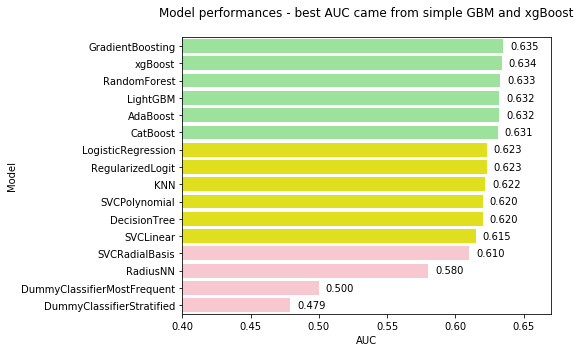

In [24]:
fig, ax = plt.subplots(figsize = (8, 5))

g = sns.barplot(x = 'AUC', y = 'Model', data = model_comparison, ax = ax,
                palette = ['lightgreen' if (x > 0.63) else ('yellow' if (x > 0.61) else 'pink') for x in model_comparison['AUC']])

for p in ax.patches:
    width = p.get_width()    
    ax.text(width + 0.005, p.get_y() + p.get_height() / 2, 
            '{:1.3f}'.format(width), ha = 'left', va = 'center', size = 10) 
    
plt.title('Model performances - best AUC came from simple GBM and xgBoost\n')
plt.tight_layout()
plt.xlim(0.4, 0.67)
plt.show()

Simple GBM and xgBoost seem to have the best performance on test data, having the highest AUC scores among all models. I'll use SHAP to interpret and explain what the GBM algo does

In [25]:
# one hot encoded Xs
X_train = pd.read_csv('../../data/bank/X_train.csv')
X_test = pd.read_csv('../../data/bank/X_test.csv')

#Ys
y_train = np.array(pd.read_csv('../../data/bank/y_train.csv'))
y_test = np.array(pd.read_csv('../../data/bank/y_test.csv'))

### Explaining CatBoost model's feature importances, dependencies and effects

In [26]:
pkl_filename = 'saved_models/GBM.pkl'

with open(pkl_filename, 'rb') as file:
    GBM = pickle.load(file)

Re-evaluate preformance on test set

In [27]:
evaluate_model('GBM', GBM, X_test, y_test)

Accuracy for GBM : 0.614
F score for GBM : 0.249
AUC for GBM : 0.635
LogLoss for GBM : 0.672


,Accuracy,F score,AUC,LogLoss
GBM,0.614,0.249,0.635,0.672


#### Use SHAP values to interpret model

In [28]:
shap.initjs()

In [56]:
GBM_explainer = shap.TreeExplainer(model = GBM, data = X_train, model_output = 'probability')
GBM_shap_values = GBM_explainer.shap_values(X_train)

 99%|===================| 6112/6202 [00:36<00:00]        

Here the raw output would be the log odds. Dealing with it:
1. e^x = predicted probability - calculating manually using np.exp()
2. Setting model output to probability, then the predicted probability will be explained, not how the log odds were changing

In [86]:
print(np.exp(GBM.predict_log_proba(X_train)[0][1]) == GBM.predict_proba(X_train)[0][1])

print('The predicted log odds are:', GBM.predict_log_proba(X_train)[0][1])
print('The predicted probability is:', GBM.predict_proba(X_train)[0][1])

True
The predicted log odds are: -0.764757813767875
The predicted probability is: 0.4654466420937257


#### 1. Variable Importances

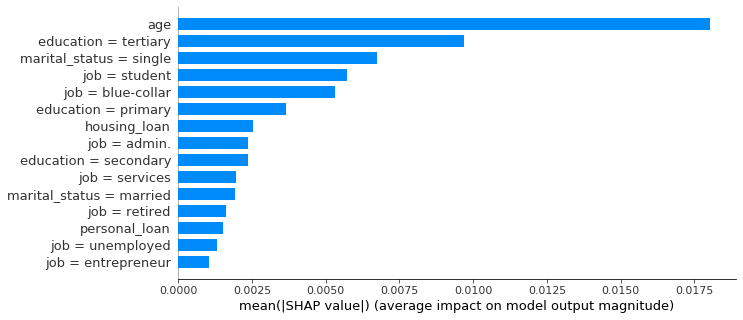

In [57]:
shap.summary_plot(GBM_shap_values, X_train, plot_type = 'bar', plot_size = (10, 5), max_display = 15)

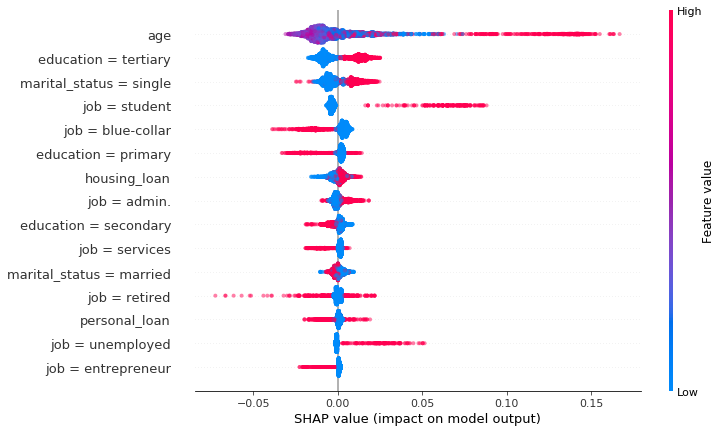

In [58]:
shap.summary_plot(GBM_shap_values, X_train, plot_type = 'dot', plot_size = (10, 7), alpha = 1/2, max_display = 15)

#### 2. Dependence plots

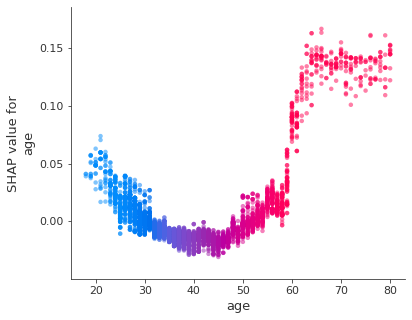

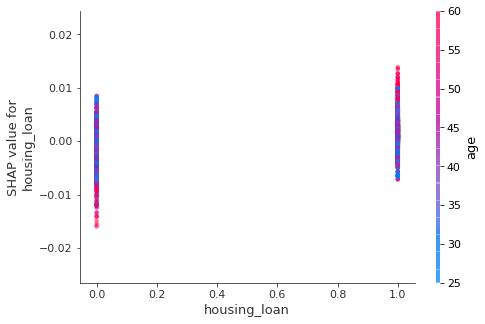

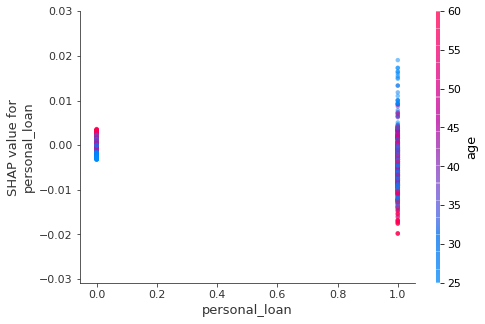

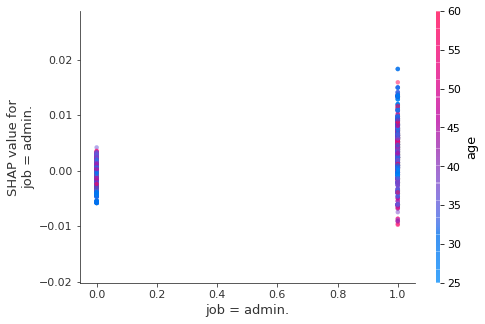

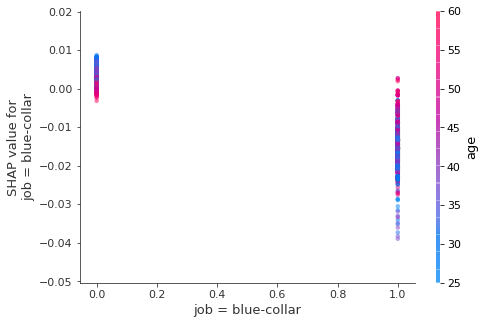

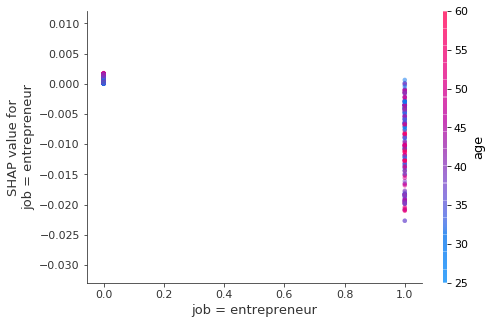

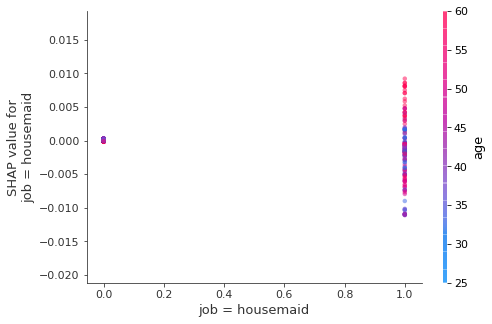

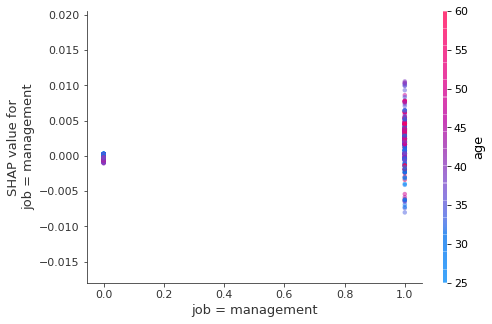

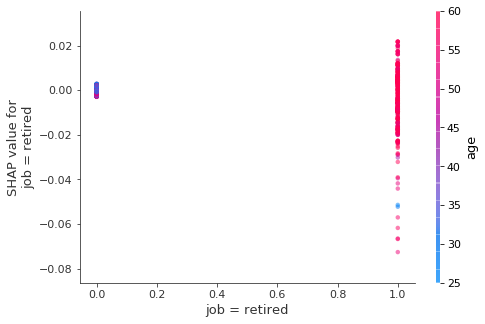

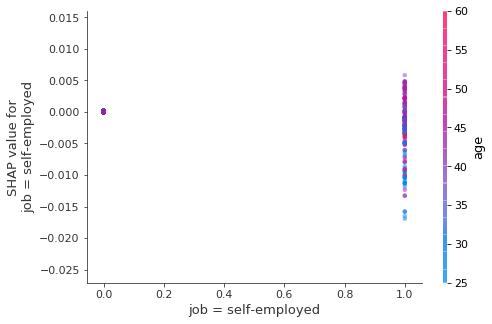

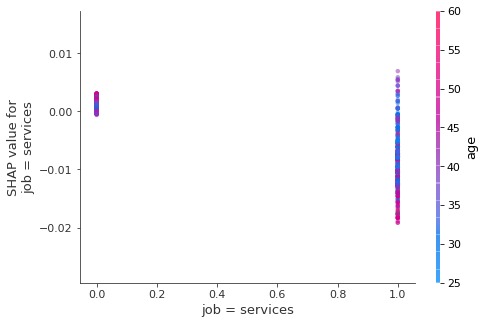

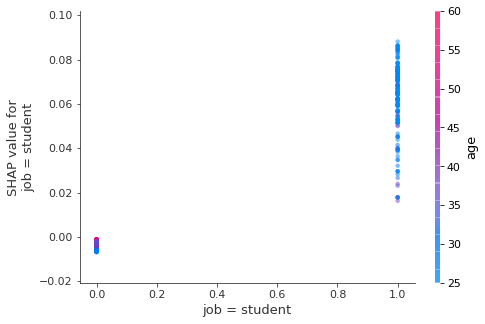

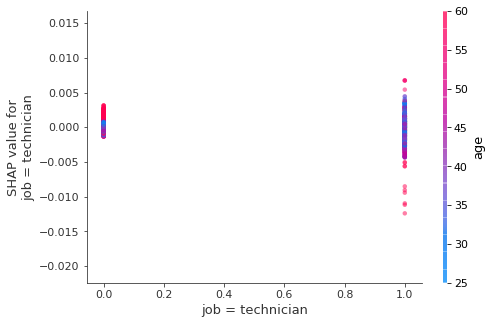

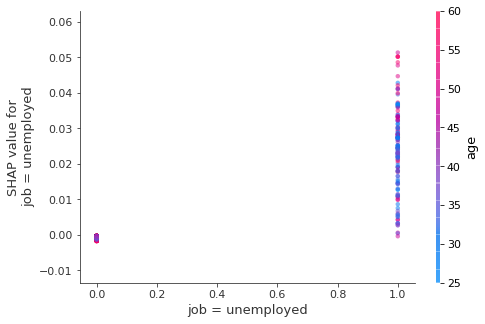

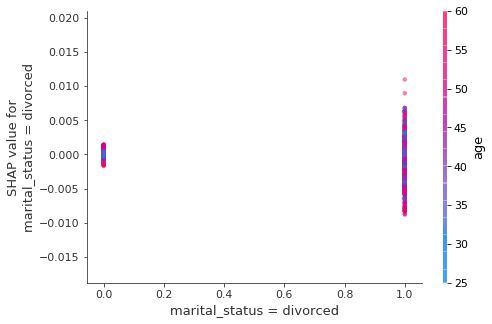

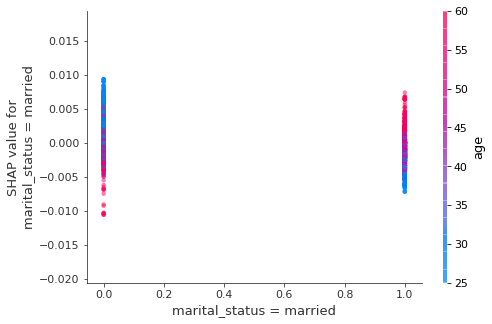

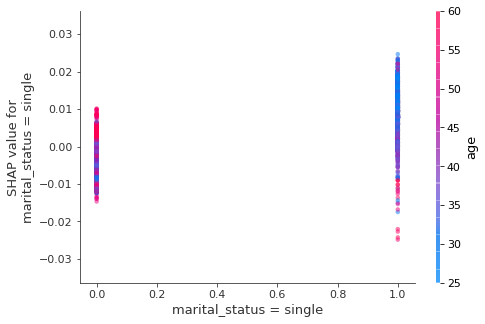

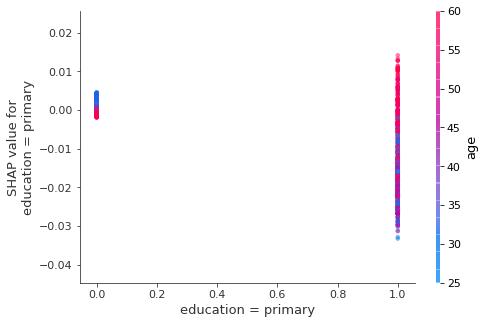

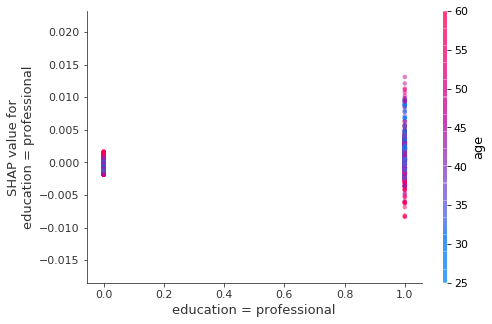

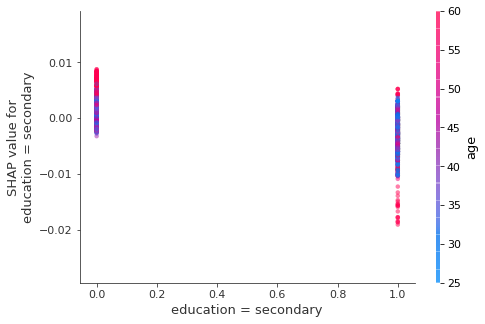

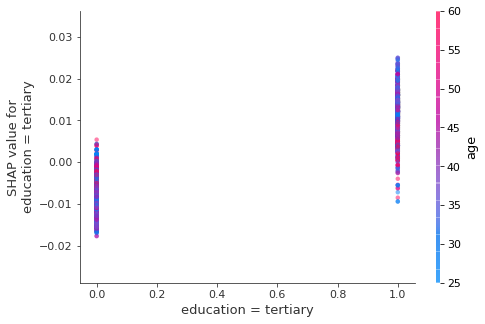

In [59]:
for name in X_train.columns:
    shap.dependence_plot(name, GBM_shap_values, X_train, dot_size = 20, alpha = 1/2, interaction_index = 'age')

#### 3. Prediction explanation plots

Visualize 1 or more prediction's explanation

In [72]:
shap.force_plot(GBM_explainer.expected_value, GBM_shap_values[2075,:], X_train.iloc[2075,:]) #plot_cmap=['#32CD32', '#B22222'])

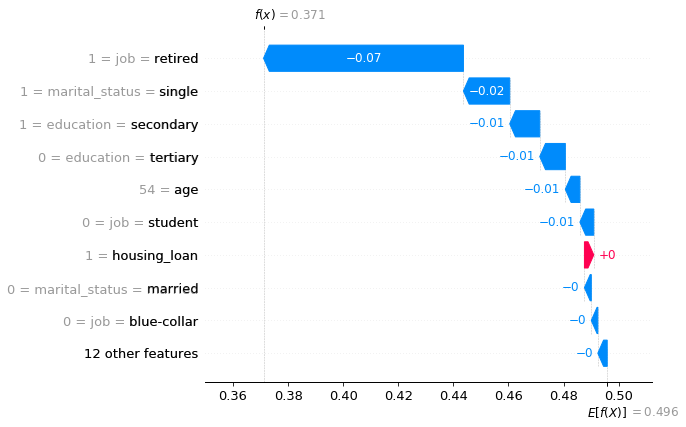

In [73]:
shap.plots._waterfall.waterfall_legacy(GBM_explainer.expected_value, GBM_shap_values[2075, :], 
                                       features = X_train.iloc[2075,:], )

In [74]:
shap.force_plot(GBM_explainer.expected_value, GBM_shap_values[0:100,:], X_train.iloc[0:100,:]) #plot_cmap=['#32CD32', '#B22222'])

Use decision plots

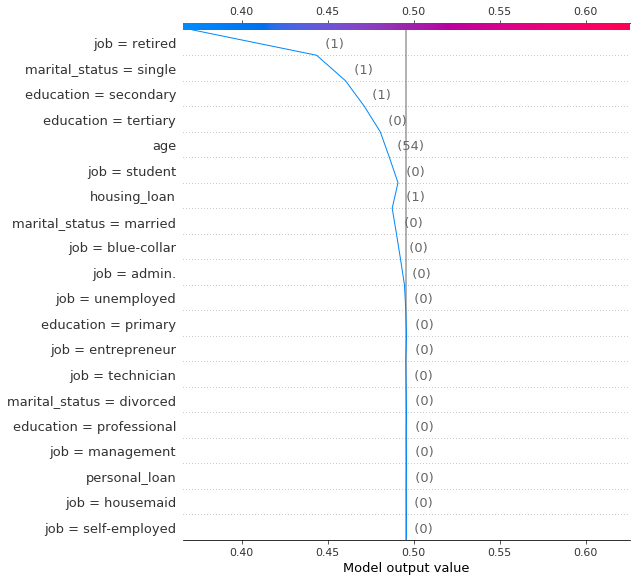

In [75]:
shap.decision_plot(GBM_explainer.expected_value, GBM_shap_values[2075,:], 
                   features = X_train.iloc[2075,:], )

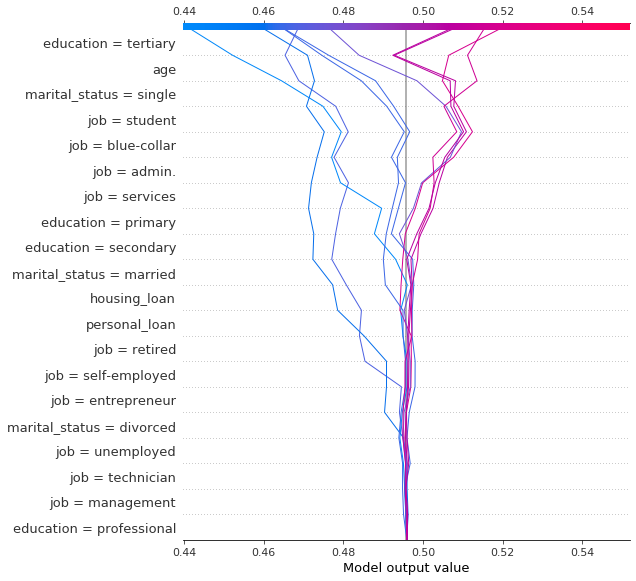

In [76]:
shap.decision_plot(GBM_explainer.expected_value, GBM_shap_values[0:10,:], 
                   features = X_train.iloc[0:10,:])